In [1]:
import os


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printed

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
tf.random.set_seed(0)
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer,MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

from tensorflow import keras
from keras.layers import Input, Conv1D, Dropout, MaxPooling1D, Flatten, Dense, GRU
from keras.models import Sequential
from keras.layers import concatenate
from sklearn.model_selection import train_test_split


<h1>1. Load data</h1>
    set the load data row number
    set colunms names
    remove useless colunms

In [4]:
row_num = 65000
test_num= 10000

In [5]:
dos_data = pd.read_csv("/home/muzammil/PycharmProjects/Intrusion Detection in the Internet of Vehicles/data/DoS_dataset.csv",nrows=row_num, header=None)
dos_data.tail()

,0,1,2,3,4,5,6,7,8,9,10,11
64995,1.478198e+09,0153,8,00,21,10,ff,00,ff,00,00,R
64996,1.478198e+09,0350,8,05,20,b4,68,77,00,00,8e,R
64997,1.478198e+09,0130,8,0f,80,00,ff,13,80,03,2a,R
64998,1.478198e+09,0131,8,e0,7f,00,00,1a,7f,03,0b,R
64999,1.478198e+09,0140,8,00,00,00,00,0a,22,23,48,R


In [6]:
col_names = ['time_stamp','id', 'dlc','d0','d1','d2','d3','d4','d5','d6','d7','R']
dos_data = dos_data.dropna()

In [7]:
dos_data.columns = col_names

In [8]:
dos_data.head()

,time_stamp,id,dlc,d0,d1,d2,d3,d4,d5,d6,d7,R
0,1.478198e+09,0316,8,05,21,68,09,21,21,00,6f,R
1,1.478198e+09,018f,8,fe,5b,00,00,00,3c,00,00,R
2,1.478198e+09,0260,8,19,21,22,30,08,8e,6d,3a,R
3,1.478198e+09,02a0,8,64,00,9a,1d,97,02,bd,00,R
4,1.478198e+09,0329,8,40,bb,7f,14,11,20,00,14,R


In [9]:
dos_data['R'].describe()

count     64525
unique        2
top           R
freq      48336
Name: R, dtype: object

In [10]:
dos_data.R.unique()

array(['R', 'T'], dtype=object)

In [11]:
dos_data.drop(['time_stamp','dlc','R'], inplace=True, axis=1)

In [12]:
dos_data.tail()

,id,d0,d1,d2,d3,d4,d5,d6,d7
64995,0153,00,21,10,ff,00,ff,00,00
64996,0350,05,20,b4,68,77,00,00,8e
64997,0130,0f,80,00,ff,13,80,03,2a
64998,0131,e0,7f,00,00,1a,7f,03,0b
64999,0140,00,00,00,00,0a,22,23,48


<h1>2. Create features</h1>
convert consequtive records into matrix freature according to <a href="https://www.sciencedirect.com/science/article/abs/pii/S2214209619302451">PAPER</a>

Note: we use integer instead of binary in this notebook



In [13]:
scaler = MinMaxScaler()

In [14]:
def create_feature(data_frame,label,n=30,m=9):
    feature_list = []
    nrow = data_frame.shape[0]
    scale_colums = ['id', 'd0', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7']
    for col  in dos_data.columns:
        data_frame[col] = data_frame[col].apply(int, base=16)
    data_frame[scale_colums] = scaler.fit_transform(data_frame[scale_colums])
    for i in range(0,nrow,n):
        if nrow >=  i+n:
            tem_file = data_frame.iloc[i:i+n,:].values
            feature_list.append(tem_file)
    feature_df = pd.DataFrame(data={"features":feature_list,"label":[label]*len(feature_list)})
    return feature_df

In [15]:
dos_feature_df = create_feature(dos_data, "dos")

In [16]:
dos_feature_df.shape

(2150, 2)

In [17]:
dos_feature_df.head()

,features,label
0,"[[0.4702380952380953, 0.0196078431372549, 0.17...",dos
1,"[[0.18095238095238098, 0.043137254901960784, 0...",dos
2,"[[0.8029761904761905, 0.8470588235294118, 0.0,...",dos
3,"[[0.4702380952380953, 0.0196078431372549, 0.17...",dos
4,"[[0.18095238095238098, 0.09411764705882353, 0....",dos


In [18]:
dos_feature_df.shape[1]

2

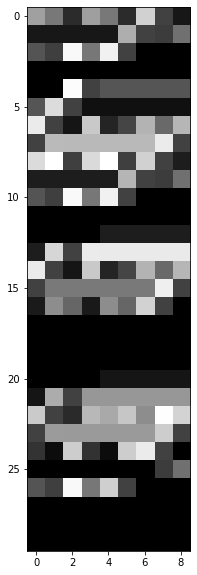

In [19]:
img = Image.fromarray(dos_feature_df['features'][1], 'L')
plt.figure(figsize=(15,10))
plt.imshow(img,'gray')

<h1>3. Repeat the above operations on the rest of dataset</h1>

In [20]:
fuzzy_data = pd.read_csv("/home/muzammil/PycharmProjects/Intrusion Detection in the Internet of Vehicles/data/Fuzzy_dataset.csv",nrows=row_num,sep=',',header=None)
fuzzy_data.columns = col_names
fuzzy_data = fuzzy_data.dropna()
fuzzy_data = fuzzy_data.drop(['time_stamp', 'dlc','R'], axis=1)
fuzzy_feature_df = create_feature(fuzzy_data,"fuzzy")
fuzzy_feature_df.head()

,features,label
0,"[[0.6590131900341963, 0.8470588235294118, 0.0,...",fuzzy
1,"[[0.4298974108451392, 0.0, 0.12549019607843137...",fuzzy
2,"[[0.16560820713238886, 0.0, 0.1294117647058823...",fuzzy
3,"[[0.32828529555446995, 0.01568627450980392, 0....",fuzzy
4,"[[0.5310210063507572, 0.06274509803921569, 0.2...",fuzzy


In [21]:
gear_data = pd.read_csv("/home/muzammil/PycharmProjects/Intrusion Detection in the Internet of Vehicles/data/gear_dataset.csv",nrows=row_num,sep=',',header=None)
gear_data.columns = col_names
gear_data = gear_data.dropna()
gear_data = gear_data.drop(['time_stamp', 'dlc','R'], axis=1)
gear_feature_df = create_feature(gear_data,"gear")
gear_feature_df.head()

,features,label
0,"[[0.18951132300357568, 0.0, 0.0, 0.0, 0.0, 0.0...",gear
1,"[[0.29499404052443384, 0.03137254901960784, 0....",gear
2,"[[0.23659117997616208, 0.996078431372549, 0.42...",gear
3,"[[0.5232419547079856, 0.0, 0.1693121693121693,...",gear
4,"[[0.200834326579261, 0.0, 0.1746031746031746, ...",gear


In [22]:
rpm_data = pd.read_csv("/home/muzammil/PycharmProjects/Intrusion Detection in the Internet of Vehicles/data/RPM_dataset.csv",nrows=row_num,sep=',',header=None)
rpm_data.columns = col_names
rpm_data = rpm_data.dropna()
rpm_data = rpm_data.drop(['time_stamp', 'dlc','R'], axis=1)
rpm_feature_df = create_feature(rpm_data,"rpm")
rpm_feature_df.head()

,features,label
0,"[[0.46960667461263406, 0.0196078431372549, 0.1...",rpm
1,"[[0.18057210965435042, 0.984313725490196, 0.69...",rpm
2,"[[0.41835518474374256, 0.08235294117647059, 0....",rpm
3,"[[0.5041716328963051, 0.0196078431372549, 0.17...",rpm
4,"[[0.1799761620977354, 0.043137254901960784, 0....",rpm


In [23]:
norm_data = pd.read_csv("/home/muzammil/PycharmProjects/Intrusion Detection in the Internet of Vehicles/data/normal_run_data.txt",nrows=row_num,sep=',',header=None)
norm_data.columns = col_names[:11]
norm_data = norm_data.dropna()
norm_data = norm_data.drop(['time_stamp', 'dlc'], axis=1)
norm_data_df = create_feature(norm_data,"norm")
norm_data_df.head()

,features,label
0,"[[0.5041716328963051, 0.0196078431372549, 0.15...",norm
1,"[[0.39928486293206195, 0.0, 0.0, 0.42125984251...",norm
2,"[[0.18057210965435042, 0.9490196078431372, 0.5...",norm
3,"[[0.6471990464839094, 1.0, 0.0, 0.0, 0.0, 1.0,...",norm
4,"[[0.39928486293206195, 0.12549019607843137, 0....",norm


<h1>4. Combine the loaded datasets
</h1>

In [24]:
final_data = pd.concat([dos_feature_df,fuzzy_feature_df,gear_feature_df,rpm_feature_df,norm_data_df], ignore_index=True)
final_data.head()

,features,label
0,"[[0.4702380952380953, 0.0196078431372549, 0.17...",dos
1,"[[0.18095238095238098, 0.043137254901960784, 0...",dos
2,"[[0.8029761904761905, 0.8470588235294118, 0.0,...",dos
3,"[[0.4702380952380953, 0.0196078431372549, 0.17...",dos
4,"[[0.18095238095238098, 0.09411764705882353, 0....",dos


In [25]:
final_data = shuffle(final_data)
final_data.head()

,features,label
5923,"[[0.46960667461263406, 0.0196078431372549, 0.1...",gear
8123,"[[0.6471990464839094, 1.0, 0.0, 0.0, 0.0, 1.0,...",rpm
1537,"[[0.1904761904761905, 0.0, 0.0, 0.0, 0.0, 0.09...",dos
1075,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...",dos
10032,"[[0.5041716328963051, 0.0196078431372549, 0.15...",norm


In [26]:
final_data.label.unique()

array(['gear', 'rpm', 'dos', 'norm', 'fuzzy'], dtype=object)

In [27]:
final_data.features.shape

(10530,)

In [28]:
encoder = LabelBinarizer()

In [29]:
transfomed_label = encoder.fit_transform(final_data.label)

In [30]:
a = final_data.features[0]
a.shape

(30, 9)

In [31]:
n_time_steps = 30
n_features = 9
n_epoch = 150

In [32]:
(n_features,n_time_steps)

(9, 30)

In [239]:
model = Sequential([
# Input((n_time_steps,9)),
Conv1D(input_shape=(n_time_steps,n_features),filters=16, kernel_size=3,activation='relu'),
Conv1D(filters=16, kernel_size=3,activation='relu'),
Conv1D(filters=32, kernel_size=3,activation='relu'),
Conv1D(filters=32, kernel_size=3,activation='relu'),
MaxPooling1D(pool_size=16, padding="same"),


Flatten(),
Dense(8, activation='relu'),
Dense(4, activation='relu'),
Dense(5, activation='softmax')
])


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [240]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_88 (Conv1D)          (None, 28, 16)            448       
                                                                 
 conv1d_89 (Conv1D)          (None, 26, 16)            784       
                                                                 
 conv1d_90 (Conv1D)          (None, 24, 32)            1568      
                                                                 
 conv1d_91 (Conv1D)          (None, 22, 32)            3104      
                                                                 
 max_pooling1d_24 (MaxPoolin  (None, 2, 32)            0         
 g1D)                                                            
                                                                 
 flatten_20 (Flatten)        (None, 64)                0         
                                                     

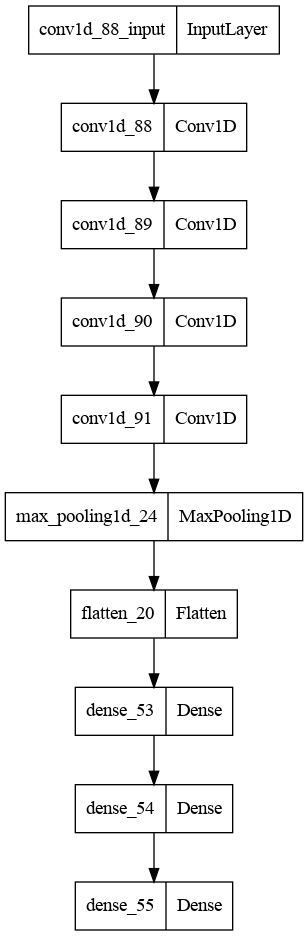

In [241]:
tf.keras.utils.plot_model(model)

In [33]:
features = np.concatenate(final_data.features.values)
features = features.reshape(-1,n_time_steps,n_features)

In [34]:
features.shape

(10530, 30, 9)

In [35]:
x_train, x_test , y_train, y_test=train_test_split(features,transfomed_label,test_size=0.2, random_state=42)

In [36]:
print("X-train:", x_train.shape)
print("y-train:", y_train.shape)
print("------------------------")
print("X-test:", x_test.shape)
print("y-test:", y_test.shape)

X-train: (8424, 30, 9)
y-train: (8424, 5)
------------------------
X-test: (2106, 30, 9)
y-test: (2106, 5)


In [246]:
history = model.fit(x_train,y_train, epochs=500, batch_size=512,
                    validation_data=(x_test, y_test))

Epoch 1/500
17/17 [==============================] - 2s 36ms/step - loss: 1.5880 - categorical_accuracy: 0.2665 - val_loss: 1.5622 - val_categorical_accuracy: 0.2745
Epoch 2/500
17/17 [==============================] - 0s 24ms/step - loss: 1.5121 - categorical_accuracy: 0.3155 - val_loss: 1.4651 - val_categorical_accuracy: 0.3139
Epoch 3/500
17/17 [==============================] - 0s 23ms/step - loss: 1.3907 - categorical_accuracy: 0.3488 - val_loss: 1.3428 - val_categorical_accuracy: 0.3352
Epoch 4/500
17/17 [==============================] - 0s 25ms/step - loss: 1.2755 - categorical_accuracy: 0.3796 - val_loss: 1.2426 - val_categorical_accuracy: 0.3727
Epoch 5/500
17/17 [==============================] - 0s 25ms/step - loss: 1.1840 - categorical_accuracy: 0.4395 - val_loss: 1.1563 - val_categorical_accuracy: 0.4535
Epoch 6/500
17/17 [==============================] - 0s 25ms/step - loss: 1.1088 - categorical_accuracy: 0.5044 - val_loss: 1.0913 - val_categorical_accuracy: 0.5233
Epoc

In [247]:
model.evaluate(x_test,y_test)

66/66 [==============================] - 0s 3ms/step - loss: 0.0330 - categorical_accuracy: 0.9900


[0.033034902065992355, 0.9900285005569458]

In [38]:
model.save("/home/muzammil/PycharmProjects/Intrusion Detection in the Internet of Vehicles/models/IDS-IoV.h5")

In [39]:
model=tf.keras.models.load_model("/home/muzammil/PycharmProjects/Intrusion Detection in the Internet of Vehicles/models/IDS-IoV.h5")

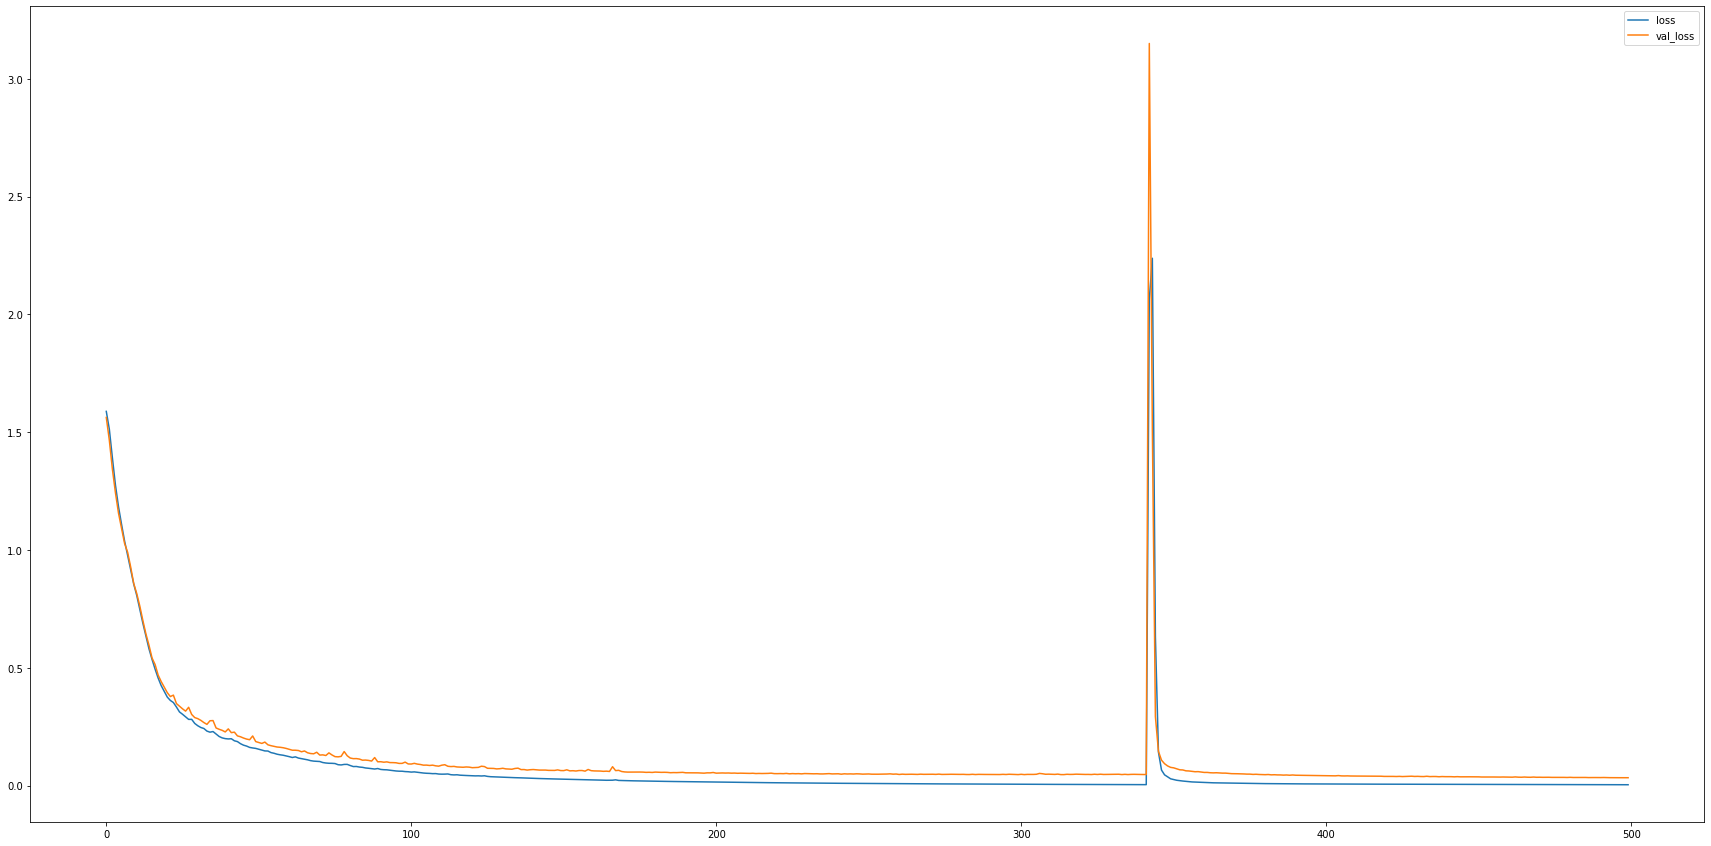

In [250]:
x = list(range(500))
plt.figure(figsize=(30,15))
plt.plot(x, history.history['loss'],label="loss")
plt.plot(x, history.history['val_loss'],label="val_loss")
plt.legend();

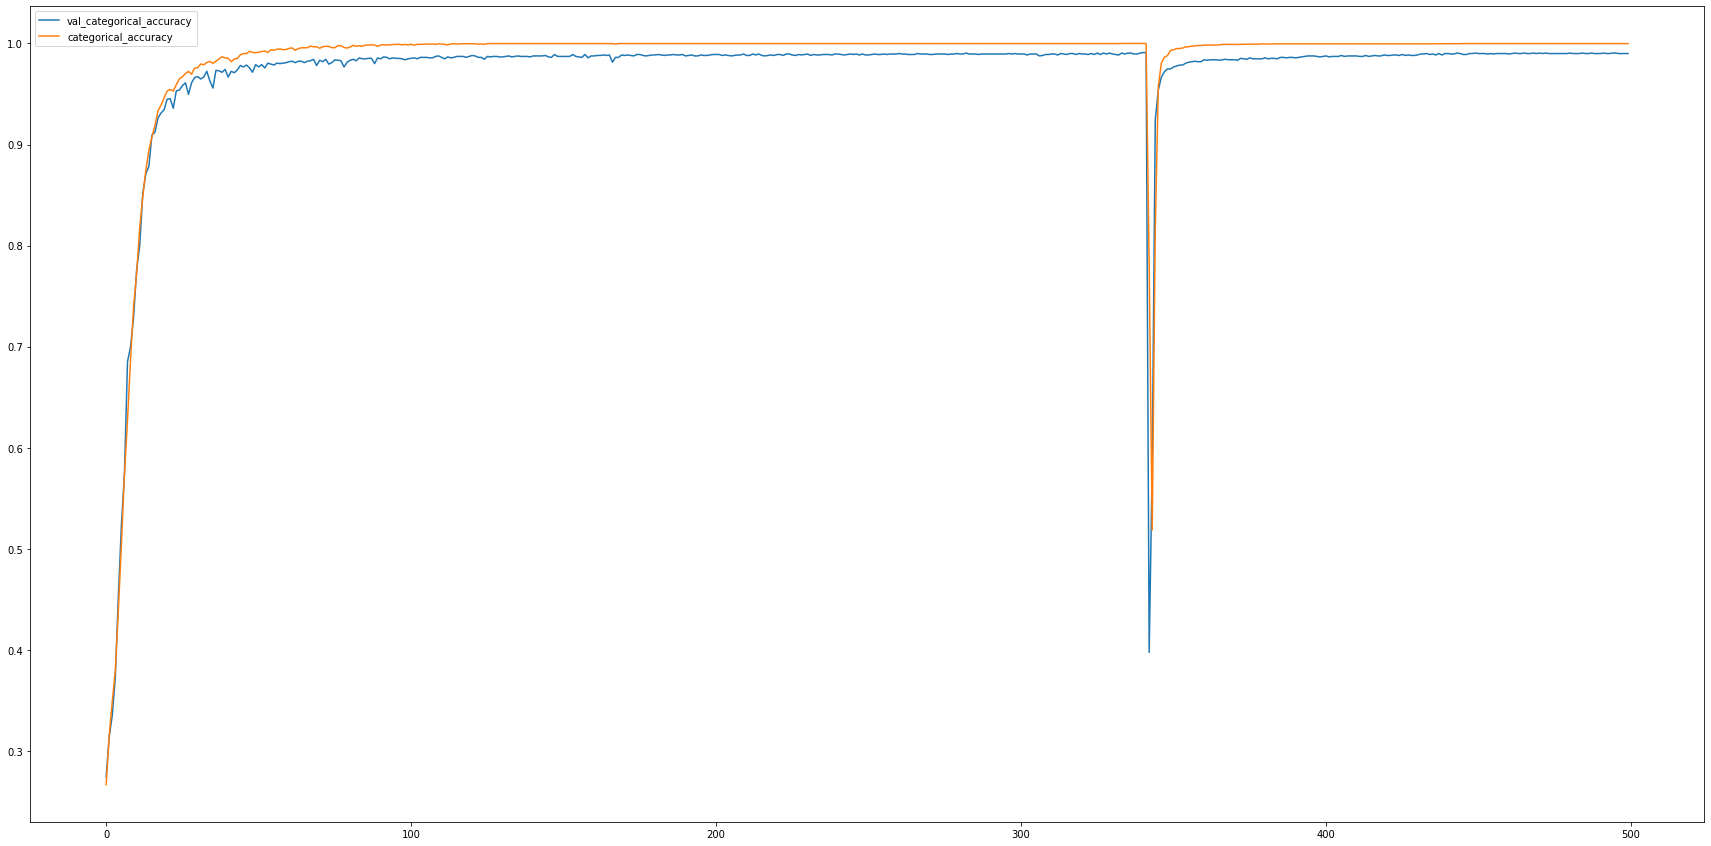

In [251]:
plt.figure(figsize=(30,15))
plt.plot(x, history.history['val_categorical_accuracy'],label="val_categorical_accuracy")
plt.plot(x, history.history['categorical_accuracy'],label="categorical_accuracy")
plt.legend();

In [40]:
y_pred = model.predict(x_test)
y_obs = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

66/66 [==============================] - 0s 3ms/step


Test Accuracy:  0.9990503323836657


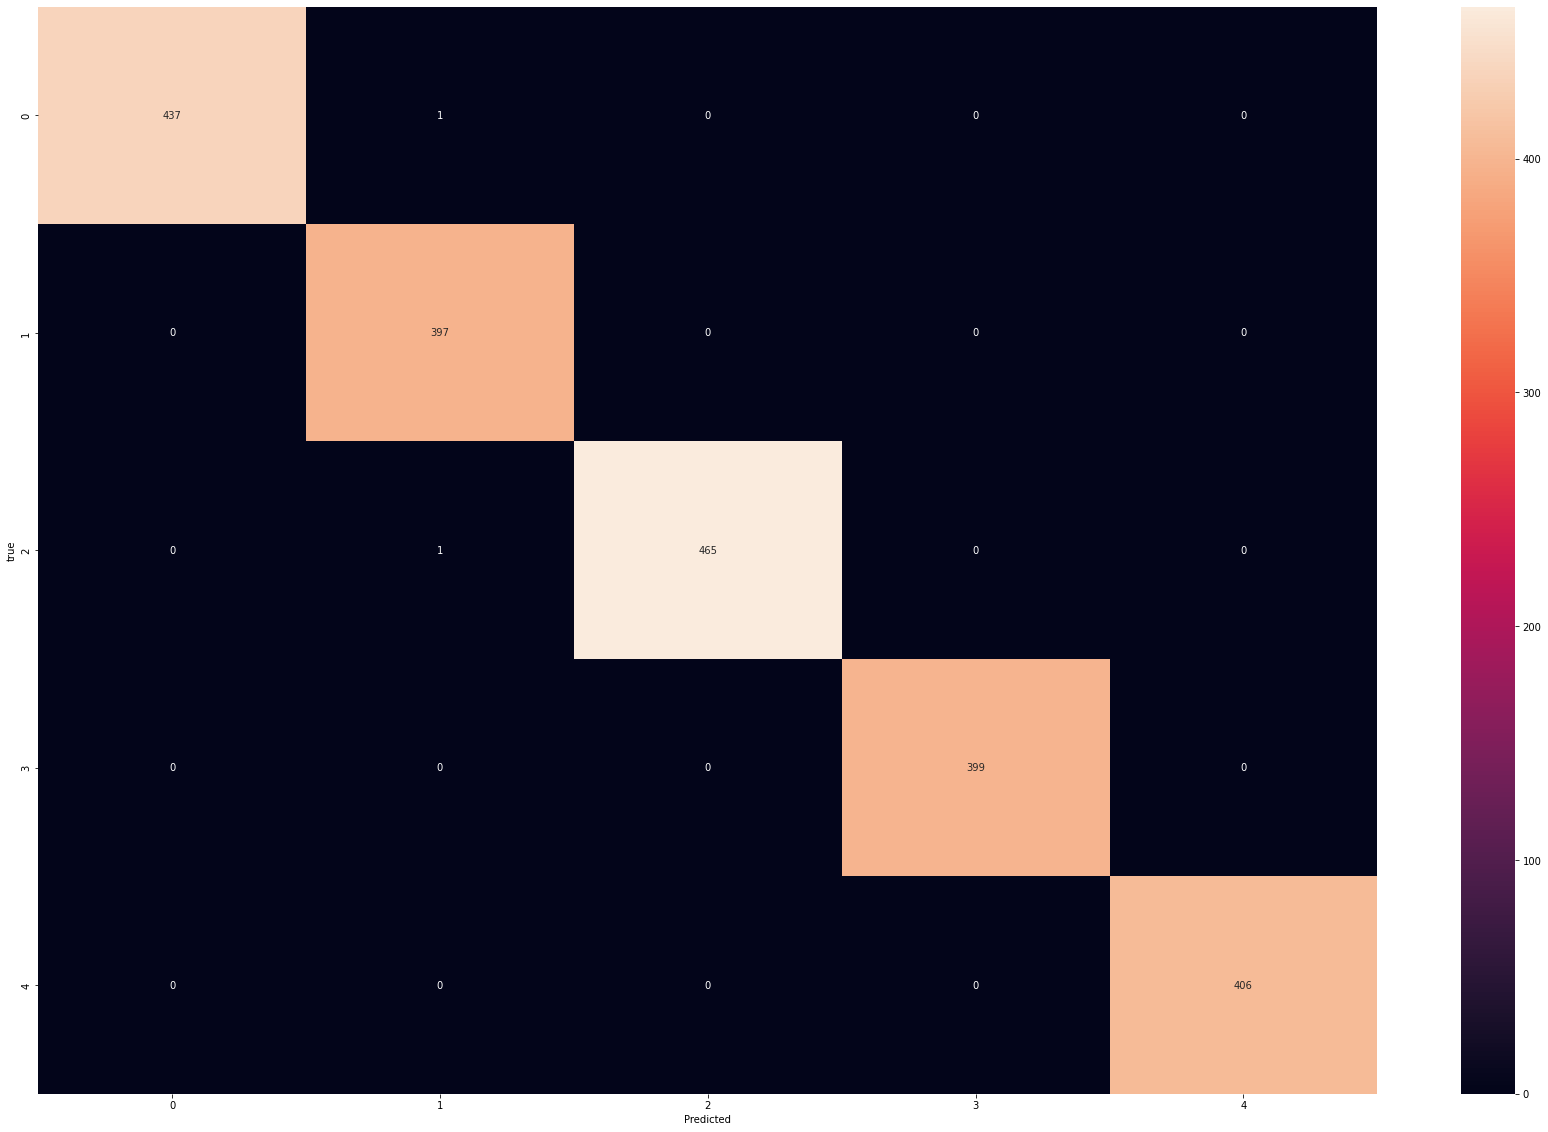

In [42]:
test_acc = accuracy_score(y_true, y_obs)
cm = confusion_matrix(y_true, y_obs )

print("Test Accuracy: ", test_acc)
fig, ax = plt.subplots(figsize=(30, 20))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("true")
plt.show()


In [43]:
print(classification_report(y_true,y_obs))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       438
           1       0.99      1.00      1.00       397
           2       1.00      1.00      1.00       466
           3       1.00      1.00      1.00       399
           4       1.00      1.00      1.00       406

    accuracy                           1.00      2106
   macro avg       1.00      1.00      1.00      2106
weighted avg       1.00      1.00      1.00      2106



<h1>Fine Tunning the Model</h1>

In [265]:
history = model.fit(x_train,y_train, epochs=500, batch_size=512,
                    validation_data=(x_test, y_test))

Epoch 1/500
17/17 [==============================] - 1s 39ms/step - loss: 4.6430e-08 - categorical_accuracy: 1.0000 - val_loss: 0.0525 - val_categorical_accuracy: 0.9948
Epoch 2/500
17/17 [==============================] - 0s 24ms/step - loss: 4.6557e-08 - categorical_accuracy: 1.0000 - val_loss: 0.0517 - val_categorical_accuracy: 0.9948
Epoch 3/500
17/17 [==============================] - 0s 23ms/step - loss: 4.6416e-08 - categorical_accuracy: 1.0000 - val_loss: 0.0520 - val_categorical_accuracy: 0.9948
Epoch 4/500
17/17 [==============================] - 0s 27ms/step - loss: 4.6416e-08 - categorical_accuracy: 1.0000 - val_loss: 0.0520 - val_categorical_accuracy: 0.9948
Epoch 5/500
17/17 [==============================] - 0s 23ms/step - loss: 4.6303e-08 - categorical_accuracy: 1.0000 - val_loss: 0.0523 - val_categorical_accuracy: 0.9948
Epoch 6/500
17/17 [==============================] - 0s 23ms/step - loss: 4.6204e-08 - categorical_accuracy: 1.0000 - val_loss: 0.0521 - val_categoric

In [260]:
model.save("/home/muzammil/PycharmProjects/Intrusion Detection in the Internet of Vehicles/models/ID-IoV.h5")

In [46]:
model1 = Sequential([
# Input((n_time_steps,9)),
Conv1D(input_shape=(n_time_steps,n_features),filters=16, kernel_size=3,activation='relu'),
Conv1D(filters=16, kernel_size=3,activation='relu'),
Conv1D(filters=32, kernel_size=3,activation='relu'),
Conv1D(filters=32, kernel_size=3,activation='relu'),
MaxPooling1D(pool_size=16, padding="same"),
GRU(100, return_sequences=True),

Flatten(),
Dense(8, activation='relu'),
Dense(4, activation='relu'),
Dense(5, activation='softmax')
])


model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [48]:
history1 = model1.fit(x_train,y_train, epochs=500, batch_size=1024,
                    validation_data=(x_test, y_test))

Epoch 1/500
9/9 [==============================] - 1s 74ms/step - loss: 0.0268 - categorical_accuracy: 0.9926 - val_loss: 0.0549 - val_categorical_accuracy: 0.9801
Epoch 2/500
9/9 [==============================] - 1s 61ms/step - loss: 0.0233 - categorical_accuracy: 0.9941 - val_loss: 0.0595 - val_categorical_accuracy: 0.9782
Epoch 3/500
9/9 [==============================] - 1s 60ms/step - loss: 0.0222 - categorical_accuracy: 0.9950 - val_loss: 0.0563 - val_categorical_accuracy: 0.9796
Epoch 4/500
9/9 [==============================] - 1s 61ms/step - loss: 0.0204 - categorical_accuracy: 0.9958 - val_loss: 0.0539 - val_categorical_accuracy: 0.9801
Epoch 5/500
9/9 [==============================] - 1s 59ms/step - loss: 0.0194 - categorical_accuracy: 0.9956 - val_loss: 0.0556 - val_categorical_accuracy: 0.9777
Epoch 6/500
9/9 [==============================] - 1s 60ms/step - loss: 0.0195 - categorical_accuracy: 0.9960 - val_loss: 0.0624 - val_categorical_accuracy: 0.9734
Epoch 7/500
9/9 